In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer#for word embedding
# import gensim
# from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/francesco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'&', 'and', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r't\.co\S+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = ps.stem(text)
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)


In [3]:
raw = pd.read_parquet('df.parquet.gzip')
# unsupervised = raw[raw["tweetcreatedts"] >= '2022-03-03']
data = raw[raw["tweetcreatedts"] < '2022-03-03']

# data, unsupervised = train_test_split(raw, test_size=0.5, random_state=42, shuffle=True)
data.head()

,tweetid,tweetcreatedts,language,location,text,hashtags,clean_text
149212,1498447926531887104,2022-03-01,en,None,It’s all a game and anonymous cowards are runn...,"[{'text': 'coronavirus', 'indices': [78, 90]},...",game anonymous coward run show behind curtain ...
149213,1498447927009693697,2022-03-01,en,India,.@peta urges government to rescue student alon...,"[{'text': 'UkraineRussiaWar', 'indices': [80, ...",peta urges government rescue student along com...
149214,1498447927022264320,2022-03-01,en,Texas,Instead of talking about how to save lives in ...,"[{'text': 'Ukraine', 'indices': [46, 54]}]",instead talk save life ukraine senate democrat...
149216,1498447927622176768,2022-03-01,en,"Stoney Creek, Ontario",Moscow underground. Sometimes the act of resis...,"[{'text': 'Ukraine', 'indices': [122, 130]}]",moscow underground sometimes act resistance do...
149218,1498447928033165317,2022-03-01,en,None,When you know physics and geo-politics! #Ukrai...,"[{'text': 'Ukraine', 'indices': [61, 69]}]",know physic geo politics ukrain


In [4]:
unsupervised.info()

NameError: name 'unsupervised' is not defined

In [5]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import softmax

# Function for sentiment analysis on a single text
def sentiment_analysis(text, model, tokenizer):
    # Preprocess text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Perform inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities
    probabilities = softmax(logits, dim=1).flatten().tolist()

    # Extract scores for each sentiment
    return {label: score for label, score in zip(model.config.id2label.values(), probabilities)}

# Function to handle batch processing
def batch_sentiment_analysis(texts, model, tokenizer, batch_size=16):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_results = [sentiment_analysis(text, model, tokenizer) for text in batch_texts]
        results.extend(batch_results)
    return results

# Load model and tokenizer
model_name = "michellejieli/emotion_text_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example DataFrame
# data = {'text': ["I love this!", "I hate this!", ...]}  # Replace with your data
# df = pd.DataFrame(data)
if not os.path.exists('sentiment_pivoted.parquet.gzip'):
    # Apply the batch sentiment analysis function
    data['sentiment_scores'] = batch_sentiment_analysis(data['clean_text'].tolist(), model, tokenizer, batch_size=100)
    # Convert sentiment_scores column to a DataFrame
    sentiment_df = pd.json_normalize(data['sentiment_scores'])
    
    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([data, sentiment_df], axis=1).drop(columns=['sentiment_scores'])
    result_df.to_parquet('sentiment_pivoted.parquet.gzip', compression='gzip')

In [6]:
df = pd.read_parquet('sentiment_pivoted.parquet.gzip')
df = df.dropna(subset=['clean_text'])
df.head()

,tweetcreatedts,language,location,text,hashtags,clean_text,anger,disgust,fear,joy,neutral,sadness,surprise
149212,2022-03-01,en,None,It’s all a game and anonymous cowards are runn...,"[{'text': 'coronavirus', 'indices': [78, 90]},...",game anonymous coward run show behind curtain ...,0.005649,0.002241,0.004141,0.026622,0.889571,0.070709,0.001067
149213,2022-03-01,en,India,.@peta urges government to rescue student alon...,"[{'text': 'UkraineRussiaWar', 'indices': [80, ...",peta urges government rescue student along com...,0.007289,0.000919,0.005890,0.538805,0.428596,0.017467,0.001033
149214,2022-03-01,en,Texas,Instead of talking about how to save lives in ...,"[{'text': 'Ukraine', 'indices': [46, 54]}]",instead talk save life ukraine senate democrat...,0.004652,0.000297,0.004030,0.069761,0.909776,0.008600,0.002885
149216,2022-03-01,en,"Stoney Creek, Ontario",Moscow underground. Sometimes the act of resis...,"[{'text': 'Ukraine', 'indices': [122, 130]}]",moscow underground sometimes act resistance do...,0.009663,0.000656,0.005110,0.015963,0.941785,0.012634,0.014189
149218,2022-03-01,en,None,When you know physics and geo-politics! #Ukrai...,"[{'text': 'Ukraine', 'indices': [61, 69]}]",know physic geo politics ukrain,0.013876,0.000557,0.002424,0.109960,0.861579,0.008876,0.002728


In [7]:
# Selecting features for clustering
X = df[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']]
X = X.fillna(0)

In [8]:
X

,anger,disgust,fear,joy,neutral,sadness,surprise
149212,0.005649,0.002241,0.004141,0.026622,0.889571,0.070709,0.001067
149213,0.007289,0.000919,0.005890,0.538805,0.428596,0.017467,0.001033
149214,0.004652,0.000297,0.004030,0.069761,0.909776,0.008600,0.002885
149216,0.009663,0.000656,0.005110,0.015963,0.941785,0.012634,0.014189
149218,0.013876,0.000557,0.002424,0.109960,0.861579,0.008876,0.002728
...,...,...,...,...,...,...,...
982578,0.033039,0.000910,0.738231,0.107564,0.072248,0.047066,0.000942
982579,0.144326,0.004390,0.407589,0.043661,0.241684,0.157378,0.000973
982580,0.044467,0.000336,0.673524,0.049731,0.186874,0.041498,0.003570
982581,0.022767,0.001000,0.244091,0.025217,0.669362,0.035916,0.001646


In [9]:
from sklearn.cluster import KMeans

k = 7  # Example value

# Applying K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
df['cluster'] = kmeans.fit_predict(X)


/home/francesco/anaconda3/envs/NLP3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f143c0164d0>
Traceback (most recent call last):
  File "/home/francesco/anaconda3/envs/NLP3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/francesco/anaconda3/envs/NLP3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/francesco/anaconda3/envs/NLP3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self

In [10]:
df

,tweetcreatedts,language,location,text,hashtags,clean_text,anger,disgust,fear,joy,neutral,sadness,surprise,cluster
149212,2022-03-01 00:00:00,en,None,It’s all a game and anonymous cowards are runn...,"[{'text': 'coronavirus', 'indices': [78, 90]},...",game anonymous coward run show behind curtain ...,0.005649,0.002241,0.004141,0.026622,0.889571,0.070709,0.001067,2
149213,2022-03-01 00:00:00,en,India,.@peta urges government to rescue student alon...,"[{'text': 'UkraineRussiaWar', 'indices': [80, ...",peta urges government rescue student along com...,0.007289,0.000919,0.005890,0.538805,0.428596,0.017467,0.001033,0
149214,2022-03-01 00:00:00,en,Texas,Instead of talking about how to save lives in ...,"[{'text': 'Ukraine', 'indices': [46, 54]}]",instead talk save life ukraine senate democrat...,0.004652,0.000297,0.004030,0.069761,0.909776,0.008600,0.002885,2
149216,2022-03-01 00:00:00,en,"Stoney Creek, Ontario",Moscow underground. Sometimes the act of resis...,"[{'text': 'Ukraine', 'indices': [122, 130]}]",moscow underground sometimes act resistance do...,0.009663,0.000656,0.005110,0.015963,0.941785,0.012634,0.014189,2
149218,2022-03-01 00:00:00,en,None,When you know physics and geo-politics! #Ukrai...,"[{'text': 'Ukraine', 'indices': [61, 69]}]",know physic geo politics ukrain,0.013876,0.000557,0.002424,0.109960,0.861579,0.008876,0.002728,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982578,2022-03-02 23:59:55,en,"Massachusetts, USA",A third and fourth explosion have now been hea...,"[{'text': 'Kyiv', 'indices': [72, 77]}]",third fourth explosion hear near kyiv metro st...,0.033039,0.000910,0.738231,0.107564,0.072248,0.047066,0.000942,3
982579,2022-03-02 23:59:56,en,None,@PeaceInuToken\nThis the #BSCGem of 2022\n💸Pri...,"[{'text': 'BSCGem', 'indices': [45, 52]}]",peaceinutoken bscgem private sale live pre sal...,0.144326,0.004390,0.407589,0.043661,0.241684,0.157378,0.000973,3
982580,2022-03-02 23:59:56,en,"Vancouver, British Columbia",Kharkiv residents are ready to give a warm wel...,"[{'text': 'StopWarInUkraine', 'indices': [84, ...",kharkiv resident ready give warm welcome occup...,0.044467,0.000336,0.673524,0.049731,0.186874,0.041498,0.003570,3
982581,2022-03-02 23:59:56,en,"East Coast, USA",Two of the largest explosions I’ve ever experi...,"[{'text': 'kyiv', 'indices': [85, 90]}]",two large explosion ive ever experience go kyiv,0.022767,0.001000,0.244091,0.025217,0.669362,0.035916,0.001646,6


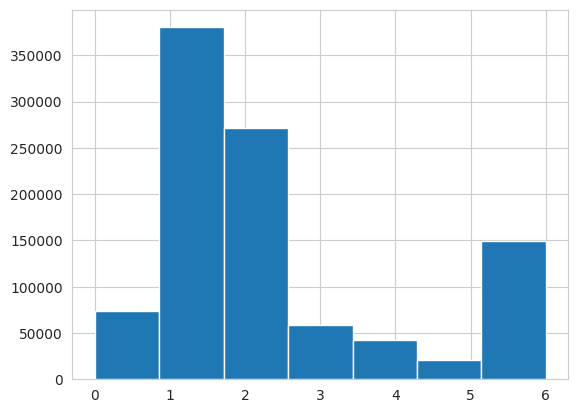

In [11]:
hist = df['cluster'].hist(bins=7)

In [13]:
# Assuming df is your DataFrame
# Group by 'clusters' and then get the mean of each emotion
cluster_summary = df[['cluster', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].groupby('cluster').mean()

# Display the summary
print(cluster_summary)

            anger   disgust      fear       joy   neutral   sadness  surprise
cluster                                                                      
0        0.027609  0.000908  0.026109  0.711480  0.205787  0.021813  0.006294
1        0.083373  0.424041  0.066931  0.087337  0.081450  0.047969  0.208898
2        0.018898  0.001116  0.020821  0.048421  0.889330  0.018147  0.003266
3        0.066816  0.001617  0.691505  0.044998  0.150070  0.041397  0.003597
4        0.712319  0.007668  0.069024  0.051569  0.114506  0.041276  0.003638
5        0.067657  0.004537  0.073356  0.085985  0.172511  0.590691  0.005264
6        0.097370  0.002740  0.129581  0.169116  0.536960  0.058695  0.005537


In [14]:
# Get detailed statistics for each cluster
detailed_stats = df[['cluster', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].groupby('cluster').describe()

# Display the detailed statistics
print(detailed_stats)

            anger                                                              \
            count      mean       std       min       25%       50%       75%   
cluster                                                                         
0         73801.0  0.027609  0.051072  0.000308  0.003535  0.008150  0.025370   
1           733.0  0.083373  0.099642  0.000439  0.006524  0.030219  0.140288   
2        271467.0  0.018898  0.028803  0.000537  0.004172  0.007947  0.019757   
3         58908.0  0.066816  0.087663  0.000298  0.011166  0.031268  0.082912   
4         42724.0  0.712319  0.185298  0.316964  0.547653  0.721149  0.881475   
5         20765.0  0.067657  0.087710  0.000265  0.006329  0.034088  0.081503   
6        149394.0  0.097370  0.106447  0.000748  0.015924  0.048812  0.152317   

                    disgust            ...   sadness            surprise  \
              max     count      mean  ...       75%       max     count   
cluster                              

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)

In [13]:
n = df.shape[0]
train_index = int(df.shape[0] * 0.8)

train_dict = df.head(train_index)[['cluster', 'clean_text']].rename(columns={"clean_text": "text", "cluster": "label"}).to_dict('list')
test_dict = df.tail(n - train_index + 1)[['cluster', 'clean_text']].rename(columns={"clean_text": "text", "cluster": "label"}).to_dict('list')

In [14]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train': Dataset.from_dict(train_dict),
    'test': Dataset.from_dict(test_dict)
})
# dataset = dataset['train']

In [15]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/797851 [00:00<?, ? examples/s]

Map:   0%|          | 0/199464 [00:00<?, ? examples/s]

In [16]:
tokenized_datasets["test"]

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 199464
})

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))

In [18]:
from transformers import AutoModelForSequenceClassification
# model_name = "SamLowe/roberta-base-go_emotions"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)
     
model_name

'michellejieli/emotion_text_classifier'

In [19]:
from transformers import TrainingArguments

# training_args = TrainingArguments(output_dir="test_trainer")
training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)


2024-01-03 15:19:40.059406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 15:19:40.059522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 15:19:40.084474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 15:19:40.134647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 15:19:41.106576: W tensorflow/compiler/tf2

In [20]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
     


/tmp/ipykernel_5662/1756248672.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
     


In [22]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=6250, training_loss=0.9867294775390625, metrics={'train_runtime': 2879.5426, 'train_samples_per_second': 34.728, 'train_steps_per_second': 2.17, 'total_flos': 1.32479210496e+16, 'train_loss': 0.9867294775390625, 'epoch': 10.0})

In [28]:
print('\aFinished!')

Finished!


In [27]:
eval_results = trainer.evaluate(eval_dataset=small_eval_dataset)
print(eval_results)

{'eval_loss': 3.2604260444641113, 'eval_accuracy': 0.2106, 'eval_runtime': 100.4012, 'eval_samples_per_second': 99.6, 'eval_steps_per_second': 3.117, 'epoch': 10.0}


In [25]:
trainer.save_model('fine_tuned')

In [26]:
model.save_pretrained("my_fine_tuned_model")

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "my_fine_tuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [3]:
unsupervised = pd.read_parquet('testset.parquet.gzip')


In [4]:
unsupervised

,tweetid,tweetcreatedts,language,location,text,hashtags,clean_text
0,1.520916e+18,2022-05-02 00:00:01,en,Canada,"📸 Russian MANPADS shot missed its target, pict...",[],russian manpad shot miss target pictured ukrai...
1,1.520916e+18,2022-05-02 00:00:06,en,"Columbus native, SE Ohio now.","No, no, Noam &gt; Chomsky Calls Trump the 'One...","[{'text': 'Ukraine', 'indices': [111, 119]}]",noam andgt chomsky call trump one western stat...
2,1.520916e+18,2022-05-02 00:00:09,en,None,The absence of compassion from the Int'l Commu...,"[{'text': 'Tigray', 'indices': [95, 102]}]",absence compassion int l community towards suf...
3,1.520916e+18,2022-05-02 00:00:11,en,Universe,R.I.P Scott and thank you. A British national ...,"[{'text': 'Ukraine', 'indices': [83, 91]}]",r p scott thank british national kill ukraine ...
4,1.520916e+18,2022-05-02 00:00:11,en,lisboa,@irmi449 @OksanaUkka 💔💔😢😢Russia stole their in...,"[{'text': 'SlavaUkraini', 'indices': [75, 88]}]",irmi oksanaukka russia stole innocence pay sla...
...,...,...,...,...,...,...,...
394350,1.531425e+18,2022-05-30 23:59:17,en,None,"@KyivIndependent Looters and thieves, the same...","[{'text': 'ArmUkraineNow', 'indices': [69, 83]...",kyivindependent looter thieve old russian army...
394351,1.531425e+18,2022-05-30 23:59:24,en,Germany,@JasminMuj Hard not to agree!\n\nBy appeasing ...,"[{'text': 'Balkans', 'indices': [95, 103]}, {'...",jasminmuj hard agree appease andamp even endor...
394352,1.531425e+18,2022-05-30 23:59:37,en,Львів,Tonight #EUCO agreed a sixth package of sancti...,"[{'text': 'EUCO', 'indices': [27, 32]}, {'text...",tonight euco agree sixth package sanction allo...
394353,1.531425e+18,2022-05-30 23:59:39,en,"Los Angeles, CA",Early today in Paris.\n\nStay with Ukraine! W...,"[{'text': 'StandWithUkraine️', 'indices': [83,...",early today paris stay ukraine victorious stan...


In [5]:
# unsupervised.to_parquet('results.parquet.gzip', compression='gzip')

# Test

In [6]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8000"


In [7]:
import torch


In [8]:
texts = unsupervised['clean_text'].tolist()
torch.cuda.empty_cache()
# Tokenize the texts
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=400)

# Move your model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare data for model
input_ids = tokenized_inputs['input_ids'].to(device)
attention_mask = tokenized_inputs['attention_mask'].to(device)
# 
# # Predict
# model.eval()
# with torch.no_grad():
#     outputs = model(input_ids, attention_mask=attention_mask)
#     predictions = torch.argmax(outputs.logits, dim=1)

In [9]:
# Define a batch size
batch_size = 32  # You can adjust this based on your GPU's memory

# Split the data into batches
def batchify(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

input_batches = batchify(input_ids, batch_size)
mask_batches = batchify(attention_mask, batch_size)

# Process each batch and collect predictions
predictions = []
for i in tqdm(range(len(input_batches))):
    batch_inputs = input_batches[i].to(device)
    batch_masks = mask_batches[i].to(device)

    with torch.no_grad():
        outputs = model(batch_inputs, attention_mask=batch_masks)
        batch_predictions = torch.argmax(outputs.logits, dim=1)
        predictions.extend(batch_predictions.cpu().numpy())

# `predictions` now contains the results for all texts


100%|██████████| 12322/12322 [31:38<00:00,  6.49it/s]


In [10]:
# Convert predictions to CPU for compatibility with Pandas
# predictions = predictions.cpu().numpy()

# Add to DataFrame
unsupervised['cluster'] = predictions

In [11]:
predictions

[2,
 2,
 2,
 6,
 2,
 6,
 2,
 3,
 2,
 2,
 2,
 6,
 3,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 5,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 6,
 2,
 3,
 2,
 6,
 0,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 0,
 2,
 6,
 6,
 3,
 2,
 2,
 2,
 2,
 0,
 2,
 6,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 6,
 2,
 6,
 3,
 3,
 2,
 5,
 6,
 0,
 2,
 3,
 0,
 2,
 6,
 2,
 6,
 5,
 5,
 2,
 6,
 6,
 0,
 0,
 6,
 6,
 3,
 6,
 6,
 2,
 2,
 1,
 5,
 2,
 6,
 6,
 2,
 2,
 6,
 5,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 6,
 6,
 2,
 2,
 2,
 2,
 1,
 2,
 6,
 2,
 6,
 2,
 6,
 5,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 6,
 3,
 2,
 0,
 0,
 0,
 6,
 0,
 6,
 6,
 6,
 6,
 2,
 6,
 1,
 1,
 0,
 2,
 6,
 3,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 6,
 6,
 6,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 6,
 2,
 2,
 2,
 2,
 0,
 4,
 5,
 6,
 6,
 6,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 6,
 3,
 2,
 2,
 6,
 2,
 1,
 6,
 6,
 6,
 2,
 6,
 0,
 6,
 0,
 6,
 2,
 2,
 2,
 0,
 2,
 0,
 5,
 2,
 2,
 2,
 3,
 6,
 2,
 2,
 2,
 6,
 2,
 2,


In [12]:
unsupervised

,tweetid,tweetcreatedts,language,location,text,hashtags,clean_text,cluster
0,1.520916e+18,2022-05-02 00:00:01,en,Canada,"📸 Russian MANPADS shot missed its target, pict...",[],russian manpad shot miss target pictured ukrai...,2
1,1.520916e+18,2022-05-02 00:00:06,en,"Columbus native, SE Ohio now.","No, no, Noam &gt; Chomsky Calls Trump the 'One...","[{'text': 'Ukraine', 'indices': [111, 119]}]",noam andgt chomsky call trump one western stat...,2
2,1.520916e+18,2022-05-02 00:00:09,en,None,The absence of compassion from the Int'l Commu...,"[{'text': 'Tigray', 'indices': [95, 102]}]",absence compassion int l community towards suf...,2
3,1.520916e+18,2022-05-02 00:00:11,en,Universe,R.I.P Scott and thank you. A British national ...,"[{'text': 'Ukraine', 'indices': [83, 91]}]",r p scott thank british national kill ukraine ...,6
4,1.520916e+18,2022-05-02 00:00:11,en,lisboa,@irmi449 @OksanaUkka 💔💔😢😢Russia stole their in...,"[{'text': 'SlavaUkraini', 'indices': [75, 88]}]",irmi oksanaukka russia stole innocence pay sla...,2
...,...,...,...,...,...,...,...,...
394350,1.531425e+18,2022-05-30 23:59:17,en,None,"@KyivIndependent Looters and thieves, the same...","[{'text': 'ArmUkraineNow', 'indices': [69, 83]...",kyivindependent looter thieve old russian army...,0
394351,1.531425e+18,2022-05-30 23:59:24,en,Germany,@JasminMuj Hard not to agree!\n\nBy appeasing ...,"[{'text': 'Balkans', 'indices': [95, 103]}, {'...",jasminmuj hard agree appease andamp even endor...,3
394352,1.531425e+18,2022-05-30 23:59:37,en,Львів,Tonight #EUCO agreed a sixth package of sancti...,"[{'text': 'EUCO', 'indices': [27, 32]}, {'text...",tonight euco agree sixth package sanction allo...,2
394353,1.531425e+18,2022-05-30 23:59:39,en,"Los Angeles, CA",Early today in Paris.\n\nStay with Ukraine! W...,"[{'text': 'StandWithUkraine️', 'indices': [83,...",early today paris stay ukraine victorious stan...,2


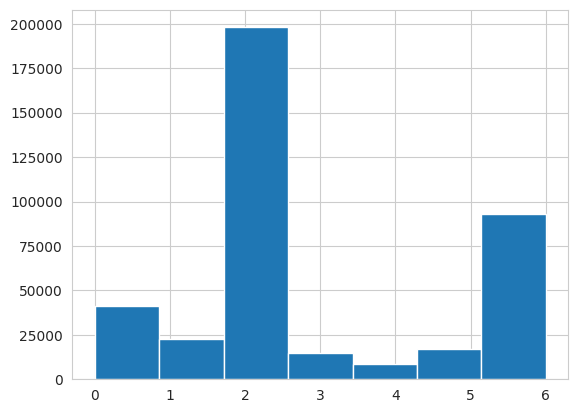

In [13]:
hist = unsupervised['cluster'].hist(bins=7)


In [14]:
unsupervised.to_csv('results.csv')

In [15]:
unsupervised

,tweetid,tweetcreatedts,language,location,text,hashtags,clean_text,cluster
0,1.520916e+18,2022-05-02 00:00:01,en,Canada,"📸 Russian MANPADS shot missed its target, pict...",[],russian manpad shot miss target pictured ukrai...,2
1,1.520916e+18,2022-05-02 00:00:06,en,"Columbus native, SE Ohio now.","No, no, Noam &gt; Chomsky Calls Trump the 'One...","[{'text': 'Ukraine', 'indices': [111, 119]}]",noam andgt chomsky call trump one western stat...,2
2,1.520916e+18,2022-05-02 00:00:09,en,None,The absence of compassion from the Int'l Commu...,"[{'text': 'Tigray', 'indices': [95, 102]}]",absence compassion int l community towards suf...,2
3,1.520916e+18,2022-05-02 00:00:11,en,Universe,R.I.P Scott and thank you. A British national ...,"[{'text': 'Ukraine', 'indices': [83, 91]}]",r p scott thank british national kill ukraine ...,6
4,1.520916e+18,2022-05-02 00:00:11,en,lisboa,@irmi449 @OksanaUkka 💔💔😢😢Russia stole their in...,"[{'text': 'SlavaUkraini', 'indices': [75, 88]}]",irmi oksanaukka russia stole innocence pay sla...,2
...,...,...,...,...,...,...,...,...
394350,1.531425e+18,2022-05-30 23:59:17,en,None,"@KyivIndependent Looters and thieves, the same...","[{'text': 'ArmUkraineNow', 'indices': [69, 83]...",kyivindependent looter thieve old russian army...,0
394351,1.531425e+18,2022-05-30 23:59:24,en,Germany,@JasminMuj Hard not to agree!\n\nBy appeasing ...,"[{'text': 'Balkans', 'indices': [95, 103]}, {'...",jasminmuj hard agree appease andamp even endor...,3
394352,1.531425e+18,2022-05-30 23:59:37,en,Львів,Tonight #EUCO agreed a sixth package of sancti...,"[{'text': 'EUCO', 'indices': [27, 32]}, {'text...",tonight euco agree sixth package sanction allo...,2
394353,1.531425e+18,2022-05-30 23:59:39,en,"Los Angeles, CA",Early today in Paris.\n\nStay with Ukraine! W...,"[{'text': 'StandWithUkraine️', 'indices': [83,...",early today paris stay ukraine victorious stan...,2
